In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import torch
import random
from tqdm import tqdm
from shapely.geometry import Polygon
import yaml
import json
import hydra

os.chdir('/home/gptrapletti/ds/satellite-multiclass-segm')

with open('config.yaml') as f:
    cfg = yaml.safe_load(f)

# <ins> FUNCTION TO TURN MASK PNGS TO SEMANTIC MASK ARRAYS

In [2]:
image_filepaths = sorted([os.path.join('data/images', filename) for filename in os.listdir(os.path.join('data/images'))])
mask_filepaths = sorted([os.path.join('data/masks', filename) for filename in os.listdir(os.path.join('data/masks'))])

len(image_filepaths), len(mask_filepaths)

(400, 400)

In [4]:
mask = cv2.imread(mask_filepaths[55])
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

mask.shape

(2000, 3000, 3)

In [5]:
category_colors = {
'background': [(112, 150, 146),
  (2, 135, 115),
  (9, 143, 150),
  (0, 0, 0),
  (119, 11, 32),
  (102, 51, 0),
  (255, 0, 0),
  (190, 153, 153),
  (0, 50, 89),
  (153, 153, 153)],
 'ground': [(128, 64, 128), (112, 103, 87), (130, 76, 0), (48, 41, 30)],
 'vegetation': [(0, 102, 0), (107, 142, 35), (51, 51, 0), (190, 250, 190)],
 'buildings': [(70, 70, 70), (102, 102, 156), (254, 228, 12), (254, 148, 12)],
 'water': [(28, 42, 168)],
 'person': [(255, 22, 96)]}

category_ids = {
    'background': 0,
    'ground': 1,
    'vegetation': 2,
    'buildings': 3,
    'water': 4,
    'person': 5
}

In [6]:
b = np.all(mask == [128, 64, 128], axis=2)
b.shape

(2000, 3000)

In [ ]:
plt.imshow(b, cmap='gray')

In [ ]:
for category in category_colors:
    for color in category_colors[category]:
        color_is_present = np.all(mask == color, axis=2)
        mask[color_is_present] = category_ids[category]      

In [ ]:
mask.shape

In [ ]:
np.unique(mask)

In [ ]:
plt.imshow(mask * 50)

In [ ]:
np.all(mask[..., 1] == mask[..., 2])

In [ ]:
np.unique(mask).tolist()

## TEST IF DATALOADER'S NUM_WORKERS MAY HELP INSTEAD OF USING LIBRARY MULTIPROCESSING

In [ ]:
from src.utils import from_png_to_semantic_mask

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, mask_filepaths):
        super().__init__()
        self.mask_filepaths = mask_filepaths
        
    def __len__(self):
        return len(self.mask_filepaths)
    
    def __getitem__(self, idx):
        mask_filepath = self.mask_filepaths[idx]
        mask = cv2.imread(mask_filepath)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        semantic_mask = from_png_to_semantic_mask(mask)
        return semantic_mask

In [ ]:
dataset = MyDataset(mask_filepaths=mask_filepaths[:10])

dataset[0].shape

In [ ]:
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=1, num_workers=0)

In [ ]:
for batch in tqdm(dataloader):
    continue

In [ ]:
batch.shape

# <INS> FIND OUT IF DATASET CAN RETURN SINGLE PATCHES

In [ ]:
# It doesn't work this way
class DummyDataset(torch.utils.data.Dataset):
    def __init__(self):
        self.data = list(range(1, 10+1))

    def __getitem__(self, index):
        number = self.data[index]
        for i in range(1, 5+1):
            patch = number + i/10
            return patch
            

    def __len__(self):
        return len(self.data)*10
    
dataset = DummyDataset()

mylist = list(dataset)

mylist

In [ ]:
# To simulate computing bounding boxes coordinates before hand and then return a single patch
class DummyDataset(torch.utils.data.Dataset):
    def __init__(self):
        self.data = list(range(1, 10+1))
        self.bounding_boxes = self.get_elements(self.data) 

    def __getitem__(self, index):
        return self.bounding_boxes[index]
            
    def get_elements(self, data):
        l = []
        for d in data:
            for i in range(1, 5+1):
                l.append(d + i/10)
        
        return l

    def __len__(self):
        return len(self.data)
    
dataset = DummyDataset()

mylist = list(dataset)

mylist

Let's try it with the satellite data

In [ ]:
image_filepaths = sorted([os.path.join('data/images', filename) for filename in os.listdir(os.path.join('data/images'))])
mask_filepaths = sorted([os.path.join('data/masks', filename) for filename in os.listdir(os.path.join('data/masks'))])

len(image_filepaths), len(mask_filepaths)

In [ ]:
image = torch.rand((3, 1500, 2000))

image.shape

In [5]:
def get_random_bbox(side, max_height, max_width):
    top_left = random.randint(0, max_height - side), random.randint(0, max_width - side)
    bottom_right = top_left[0] + side, top_left[1] + side
    return (top_left, bottom_right)

In [ ]:
# Too slow! For every patch the image is loaded again
class MyDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        image_filepaths,
    ):
        super().__init__()
        self.image_filepaths = image_filepaths
        self.n_patch_per_image = 100
        self.patch_bboxs = self.generate_patch_bboxs()
           
    def get_random_bbox(self, side, max_height, max_width):
        top_left = random.randint(0, max_height - side), random.randint(0, max_width - side)
        bottom_right = top_left[0] + side, top_left[1] + side
        return (top_left, bottom_right)
    
    def generate_patch_bboxs(self):
        patch_bboxs = []
        for i in range(len(self.image_filepaths)):
            for j in range(self.n_patch_per_image):
                filepath = image_filepaths[i]
                bbox = self.get_random_bbox(side=256, max_height=2000, max_width=3000)
                patch_bboxs.append((filepath, bbox))
        
        return patch_bboxs
                
    def __getitem__(self, idx):
        filepath = self.patch_bboxs[idx][0]
        bbox = self.patch_bboxs[idx][1]
        image = cv2.imread(filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (3000, 2000)) # cv2 wants tuple (width, height)
        patch = image[bbox[0][0]:bbox[1][0], bbox[0][1]:bbox[1][1], :]
        return patch

    def __len__(self):
        return len(self.patch_bboxs)

In [ ]:
dataset = MyDataset(image_filepaths=image_filepaths[:300])
len(dataset.patch_bboxs)

In [ ]:
idx = random.randint(0, len(dataset)-1)
a = dataset[idx]
print(idx, a.shape)

plt.imshow(a)

In [ ]:
for i in tqdm(range(len(dataset))):
    patch = dataset[i]
    
# 2h 45min

In [ ]:
# Cached version
from collections import OrderedDict

class MyCachedDataset(torch.utils.data.Dataset):
    def __init__(self, image_filepaths, cache_size=10):
        super().__init__()
        self.image_filepaths = image_filepaths
        self.n_patch_per_image = 100
        self.patch_bboxs = self.generate_patch_bboxs()
        self.cache_size = cache_size
        self.image_cache = OrderedDict()

    def get_random_bbox(self, side, max_height, max_width):
        top_left = random.randint(0, max_height - side), random.randint(0, max_width - side)
        bottom_right = top_left[0] + side, top_left[1] + side
        return (top_left, bottom_right)
    
    def generate_patch_bboxs(self):
        patch_bboxs = []
        for i in range(len(self.image_filepaths)):
            for j in range(self.n_patch_per_image):
                filepath = image_filepaths[i]
                bbox = self.get_random_bbox(side=256, max_height=2000, max_width=3000)
                patch_bboxs.append((filepath, bbox))
        
        return patch_bboxs

    def load_and_process_image(self, filepath):
        if filepath in self.image_cache:
            # Return cached image if it's in the cache
            image = self.image_cache[filepath]
            # Move the accessed entry to the end (to show it's recently used)
            self.image_cache.move_to_end(filepath)
        else:
            image = cv2.imread(filepath)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (3000, 2000))
            
            # Add the loaded image to the cache
            self.image_cache[filepath] = image
            
            # If cache exceeds size limit, remove the least recently used item (first item)
            if len(self.image_cache) > self.cache_size:
                self.image_cache.popitem(last=False)
        
        return image

    def __getitem__(self, idx):
        filepath = self.patch_bboxs[idx][0]
        bbox = self.patch_bboxs[idx][1]
        image = self.load_and_process_image(filepath)
        patch = image[bbox[0][0]:bbox[1][0], bbox[0][1]:bbox[1][1], :]
        return patch
    
    def __len__(self):
        return len(self.patch_bboxs)

In [ ]:
dataset = MyCachedDataset(image_filepaths=image_filepaths[:300])
len(dataset.patch_bboxs)

In [ ]:
for i in tqdm(range(len(dataset))):
    patch = dataset[i]
    
# cached = 1m40s

# <ins> GRID SLICING

Function to find bounding box coordinates for patches extracting along a grid.

In [58]:
image_filepaths = sorted([os.path.join('data/images', filename) for filename in os.listdir(os.path.join('data/images'))])
mask_filepaths = sorted([os.path.join('data/masks', filename) for filename in os.listdir(os.path.join('data/masks'))])

len(image_filepaths), len(mask_filepaths)

(400, 400)

In [59]:
image = np.random.rand(2000, 3000, 3)
image.shape

(2000, 3000, 3)

In [60]:
side = 256
overlap = 128
max_height = 2000
max_width = 3000

In [64]:
side = 512
overlap = 0.5
max_height = 2000
max_width = 3000

increment = side - int(side*overlap)
bboxs = []
bbox_reference = ((0, 0), (256, 256))
bboxs.append(bbox_reference)

# While there is still space along the height
while bboxs[-1][1][0] < max_height:
    # While there is still space along the width
    while max_width - bboxs[-1][1][1] > increment:
        top_left = (bboxs[-1][0][0], bboxs[-1][0][1] + increment)
        bottom_right = (bboxs[-1][1][0], bboxs[-1][1][1] + increment)
        new_bbox = (top_left, bottom_right)
        bboxs.append(new_bbox)
    else:
        # If last bbox along the width tells use there is still space for one more row along the height
        if max_height - bboxs[-1][1][0] > increment:
            # Start a new row
            bbox_reference = ( (bbox_reference[0][0]+increment, bbox_reference[0][1]), (bbox_reference[1][0]+increment, bbox_reference[1][1]) )
            bboxs.append(bbox_reference)
        else:
            break
        
len(bboxs)

77

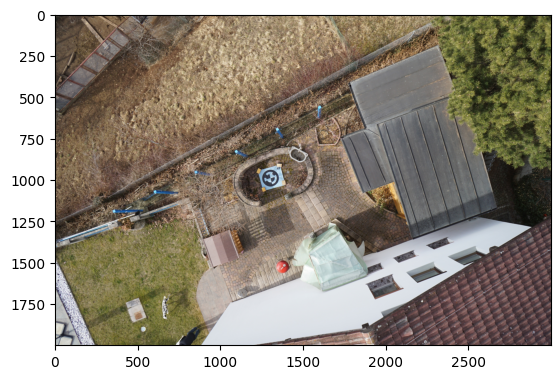

In [65]:
# Plot an image
image = cv2.imread(image_filepaths[54])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (3000, 2000))

plt.imshow(image)
plt.show()

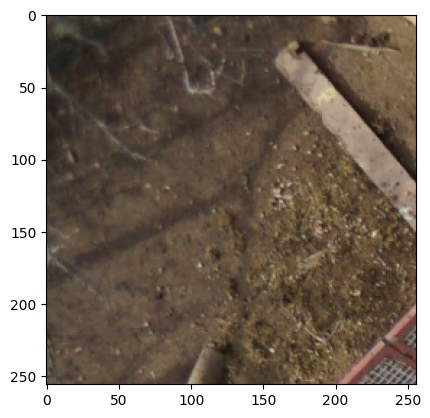

In [67]:
# Plot a patch
bbox = bboxs[0]
patch = image[bbox[0][0]:bbox[1][0], bbox[0][1]:bbox[1][1], :]

plt.imshow(patch)
plt.show()

In [ ]:
# Plot all patches
n = 22
loc = 0

for i in range(int(len(bboxs)/n)):
    fig, axs = plt.subplots(1, n, figsize=(20, 5))
    for i in range(n):    
        bbox = bboxs[loc]
        axs[i].imshow(image[bbox[0][0]:bbox[1][0], bbox[0][1]:bbox[1][1], :])
        axs[i].axis('off')
        loc += 1

Version where, if there is not space for another patch, a patch is cropped from the end of the image, going backwards.

In [68]:
side = 512
overlap = 0.50
max_height = 2000
max_width = 3000

stride = side - int(side*overlap)
n_bboxs_along_height = 1 + ((max_height - side) // stride)
n_bboxs_along_width = 1 + ((max_width - side) // stride)
print(n_bboxs_along_height, n_bboxs_along_width)

bboxs = []
bbox_reference = ((0, 0), (256, 256))
bboxs.append(bbox_reference)

for i in range(n_bboxs_along_height): ### ! +1 for the last row (manual)
    
    for j in range(n_bboxs_along_width -1): # -1?
        top_left = (bboxs[-1][0][0], bboxs[-1][0][1] + stride)
        bottom_right = (bboxs[-1][1][0], bboxs[-1][1][1] + stride)
        new_bbox = (top_left, bottom_right)
        bboxs.append(new_bbox)
        
    last_bbox = ( (bboxs[-1][0][0], max_width - side), (bboxs[-1][1][0], max_width) )
    bboxs.append(last_bbox)
       
    bbox_reference = ( (bbox_reference[0][0]+stride, bbox_reference[0][1]), (bbox_reference[1][0]+stride, bbox_reference[1][1]) )
    bboxs.append(bbox_reference)

# Remove last boox for it is out of bounds.
bboxs = bboxs[:-1] 

# Do last row (from the end of the height)
bbox_start = ( (max_height - side, 0), (max_height, side) )
bboxs.append(bbox_start)

for j in range(n_bboxs_along_width -1):
    top_left = (bboxs[-1][0][0], bboxs[-1][0][1] + stride)
    bottom_right = (bboxs[-1][1][0], bboxs[-1][1][1] + stride)
    new_bbox = (top_left, bottom_right)
    bboxs.append(new_bbox)

last_bbox = ( (bboxs[-1][0][0], max_width - side), (bboxs[-1][1][0], max_width) )
bboxs.append(last_bbox)

len(bboxs)

6 10


77

In [ ]:
# Plot patches
n = 23
loc = 0

for i in range(n_bboxs_along_height + 1):
    fig, axs = plt.subplots(1, n, figsize=(20, 5))
    for i in range(n):    
        bbox = bboxs[loc]
        axs[i].imshow(image[bbox[0][0]:bbox[1][0], bbox[0][1]:bbox[1][1], :])
        axs[i].axis('off')
        loc += 1
        

In [ ]:
# Actually extract patches
patches = []

for bbox in tqdm(bboxs):
    patch = image[bbox[0][0]:bbox[1][0], bbox[0][1]:bbox[1][1], :]
    patches.append(patch)
    
# Shape check
print(set([patch.shape for patch in patches]))

# <ins> PNG PARTIAL LOADING TEST

In [ ]:
import PIL

In [ ]:
with PIL.Image.open(image_filepaths[27]) as image:
    patch = np.array(image.crop((100, 200, 300, 400)))
    
patch.shape

# <ins> CHECK PATCH SIZE VS IMAGE SIZE

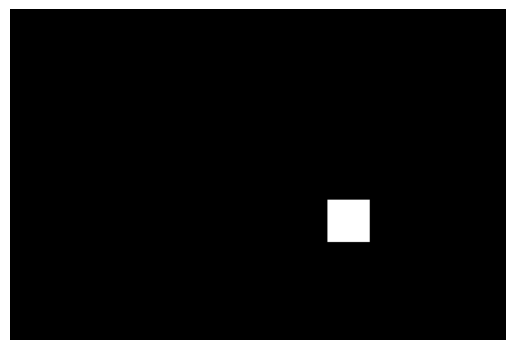

In [10]:
image = np.zeros(shape=(2000, 3000))
bbox = bboxs[222]
image[bbox[0][0]:bbox[1][0], bbox[0][1]:bbox[1][1]] = 1

plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
image = np.zeros(shape=(2000, 3000))
n_patches = 28

bboxs = [get_random_bbox(side=256, max_height=2000, max_width=3000) for i in range(n_patches)]

for bbox in bboxs:
    image[bbox[0][0]:bbox[1][0], bbox[0][1]:bbox[1][1]] = 1

plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

# <ins> RANDOM PATCH WITHOUT OVERLAP

Let's try to not return bboxs that overlap with others.

In [6]:
from src.utils import get_random_bbox, shapely_friendly_bbox

In [22]:
image_filepaths = sorted([os.path.join('data/images', filename) for filename in os.listdir(os.path.join('data/images'))])
mask_filepaths = sorted([os.path.join('data/masks', filename) for filename in os.listdir(os.path.join('data/masks'))])

len(image_filepaths), len(mask_filepaths)

(400, 400)

6


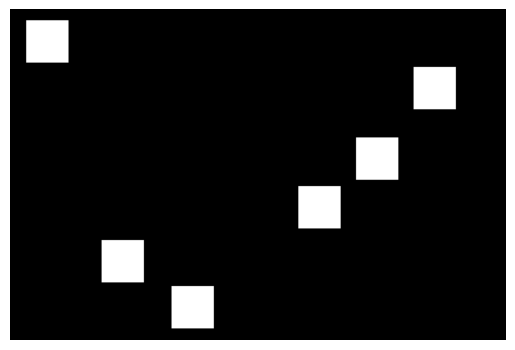

In [23]:
# It works but every patch defines a cross upon which there can't be other patches.
bboxs = []

for i in range(1000):
    bbox_i = get_random_bbox(side=256, max_height=2000, max_width=3000)
    if len(bboxs) == 0:
        bboxs.append(bbox_i)
    else:
        checks = 0
        for bbox in bboxs:
            # Check if bbox_i is not overlapping
            height_check = bbox_i[0][0] > bbox[1][0] or bbox_i[1][0] < bbox[0][0]
            width_check = bbox_i[0][1] > bbox[1][1] or bbox_i[1][1] < bbox[0][1]
            if height_check and width_check:
                checks += 1
        if checks == len(bboxs):
            bboxs.append(bbox_i)
                          
print(len(bboxs))

image = np.zeros(shape=(2000, 3000))

for bbox in bboxs:
    image[bbox[0][0]:bbox[1][0], bbox[0][1]:bbox[1][1]] = 1

plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()    

31


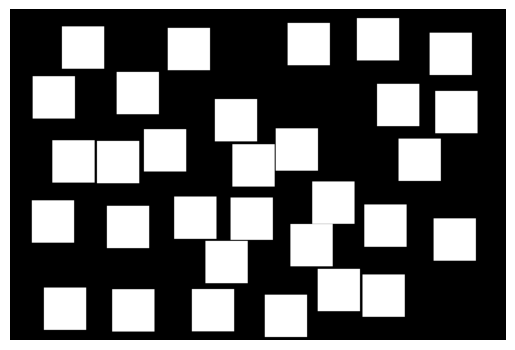

In [15]:
# Version with shapely
bboxs = []

for i in range(100):
    bbox_i = get_random_bbox(side=256, max_height=2000, max_width=3000)
    if len(bboxs) == 0:
        bboxs.append(bbox_i)
    else:
        is_overlapping = False
        bbox_i_polygon = Polygon(shapely_friendly_bbox(bbox_i))
        for bbox in bboxs:
            bbox_polygon = Polygon(shapely_friendly_bbox(bbox))
            intersection = bbox_i_polygon.intersects(bbox_polygon)
            if intersection:
                is_overlapping = True
                break
        if not is_overlapping:
            bboxs.append(bbox_i)

                          
print(len(bboxs))

image = np.zeros(shape=(2000, 3000))

for bbox in bboxs:
    image[bbox[0][0]:bbox[1][0], bbox[0][1]:bbox[1][1]] = 1

plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()    

In [24]:
# Function that given image height and width and desired number of bboxs, returns them.
def generate_random_non_overlapping_bboxs(n_bboxs, side, max_height, max_width):
    bboxs = []
    while len(bboxs) != n_bboxs:
        bbox_i = get_random_bbox(side=side, max_height=max_height, max_width=max_width)
        if len(bboxs) == 0:
            bboxs.append(bbox_i)
        else:
            is_overlapping = False
            bbox_i_polygon = Polygon(shapely_friendly_bbox(bbox_i))
            for bbox in bboxs:
                bbox_polygon = Polygon(shapely_friendly_bbox(bbox))
                intersection = bbox_i_polygon.intersects(bbox_polygon)
                if intersection:
                    is_overlapping = True
                    break
            if not is_overlapping:
                bboxs.append(bbox_i)
                
    return bboxs        

8


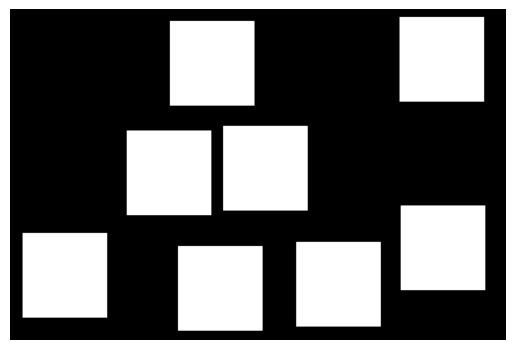

In [46]:
bboxs = generate_random_non_overlapping_bboxs(n_bboxs=8, side=512, max_height=2000, max_width=3000)

print(len(bboxs))

image = np.zeros(shape=(2000, 3000))

for bbox in bboxs:
    image[bbox[0][0]:bbox[1][0], bbox[0][1]:bbox[1][1]] = 1

plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

In [55]:
# Let's check how the number of iteractions in the while-loop scale on the basis of the number of bbboxs requested 
for n_bboxs in range(2, 10, 2):

    bboxs = []
    iteractions = 0
    while len(bboxs) != n_bboxs:
        iteractions += 1
        bbox_i = get_random_bbox(side=512, max_height=2000, max_width=3000)
        if len(bboxs) == 0:
            bboxs.append(bbox_i)
        else:
            is_overlapping = False
            bbox_i_polygon = Polygon(shapely_friendly_bbox(bbox_i))
            for bbox in bboxs:
                bbox_polygon = Polygon(shapely_friendly_bbox(bbox))
                intersection = bbox_i_polygon.intersects(bbox_polygon)
                if intersection:
                    is_overlapping = True
                    break
            if not is_overlapping:
                bboxs.append(bbox_i)
                
    print(n_bboxs, iteractions)
    
# (number of bbox, number of iteractions) (there is a certain variance though):
# - 5 5
# - 10 11
# - 15 28
# - 20 50
# - 25 61
# - 30 93
# - 35 254
# - 40 285
# - 45 3585

# Better to keep the number of bboxs per image under 30!

2 3
4 4
6 14
8 38


## IMPLEMENT STOP IF TOO MANY ITERATIONS

In [56]:
def generate_random_non_overlapping_bboxs(n_bboxs, side, max_height, max_width, max_iter=100):
    '''Generates random bounding boxes with no overlap.
    
    Args:
        n_bboxs: number of bounding boxes to generate.
        side: bounding box dimension.
        max_height: maximum height of the image.
        max_width: maximum width of the image.
        
    Returns:
        List of bounding boxes.
    '''
    bboxs = []
    iter_counter = 0
    while len(bboxs) != n_bboxs and iter_counter <= max_iter:
        iter_counter += 1
        bbox_i = get_random_bbox(side=side, max_height=max_height, max_width=max_width)
        if len(bboxs) == 0:
            bboxs.append(bbox_i)
        else:
            is_overlapping = False
            bbox_i_polygon = Polygon(shapely_friendly_bbox(bbox_i))
            for bbox in bboxs:
                bbox_polygon = Polygon(shapely_friendly_bbox(bbox))
                intersection = bbox_i_polygon.intersects(bbox_polygon)
                if intersection:
                    is_overlapping = True
                    break
            if not is_overlapping:
                bboxs.append(bbox_i)

    
    return bboxs  

In [54]:
bboxs = generate_random_non_overlapping_bboxs(n_bboxs=999, side=512, max_height=2000, max_width=3000)

len(bboxs)

10

In [65]:
# How many bboxs is it ok to expect for a given patch size
patch_side = 512

n_bboxs = []
for i in tqdm(range(100)):
    n_bboxs.append(len(generate_random_non_overlapping_bboxs(n_bboxs=999, side=patch_side, max_height=2000, max_width=3000)))
    
np.mean(n_bboxs)

100%|██████████| 100/100 [00:00<00:00, 130.41it/s]


9.31

# <ins> FUNCTION TO TURN 1-CHANNEL MASK TO 6-CHANNELS MASK

In [16]:
mask_filepaths = sorted([os.path.join('data/masks', filename) for filename in os.listdir(os.path.join('data/masks'))])

len(mask_filepaths)

400

In [17]:
mask = cv2.imread(mask_filepaths[100])[..., 0]
mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)

mask.shape, np.unique(mask)

((256, 256), array([0, 1, 2, 3, 5], dtype=uint8))

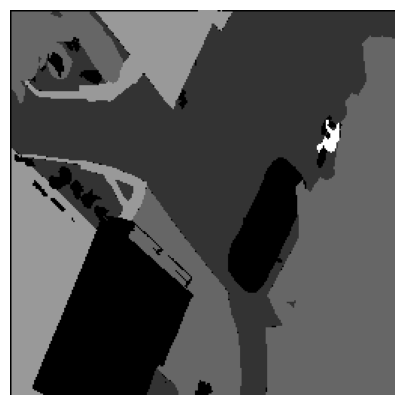

In [18]:
plt.figure(figsize=(5, 5))
plt.imshow(mask*50, cmap='gray')
plt.axis('off')
plt.show()

In [5]:
def mask_to_one_hot(mask, n_classes, size):
    '''Function to turn a mask with indexes (shape=[H, W]) to a
    one-hot encoded mask (shape=[C, H, W], where C is the number of classes).
    
    Args:
        mask: mask array.
        n_classes: number of classes.
        size: size of the mask.
        
    Returns:
        one-hot encoded mask.
    '''
    mask_hot = np.zeros(shape=(n_classes, size, size), dtype=np.uint8)
    for class_i in range(n_classes):
        mask_hot[class_i, ...] = np.where(mask == class_i, 1, 0)
        
    return mask_hot

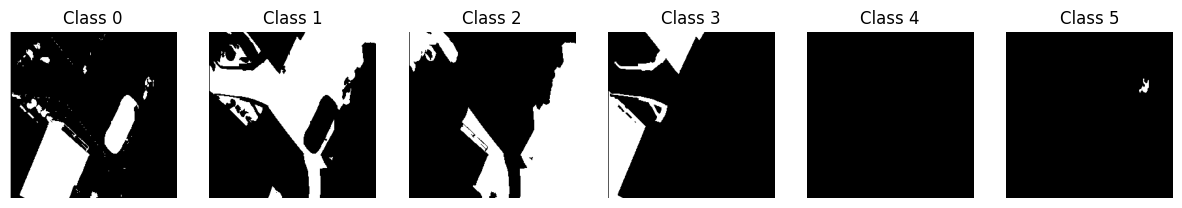

In [14]:
mask_hot = mask_to_one_hot(mask=mask, n_classes=6, size=256)

fig, axs = plt.subplots(1, mask_hot.shape[0], figsize=(15, 5))
for i in range(mask_hot.shape[0]):
    axs[i].imshow(mask_hot[i, ...], cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f'Class {i}')

In [19]:
# Alternative (seems slower looking at wall time)
mask_hot = np.eye(6)[mask]
mask_hot.shape

(256, 256, 6)

# <ins> HYDRA

In [9]:
@hydra.main(version_base=None, config_name='configs.yaml')
def load_configs(cfg):
    return cfg

cfg

{'data_path': 'data',
 'images_dir': 'data/images',
 'masks_dir': 'data/masks',
 'split_path': 'data/split.json',
 'train_split': 250,
 'val_split': 100,
 'test_split': 50,
 'n_random_patches_per_image': 28,
 'patch_size': 256,
 'patch_overlap': 0.5,
 'train_batch_size': 32,
 'val_batch_size': 32,
 'num_workers': 12,
 'loss_fn': {'_target_': 'torch.nn.BCELoss'}}

In [10]:
loss_fn = hydra.utils.instantiate(cfg['loss_fn'])
type(loss_fn)

torch.nn.modules.loss.BCELoss

# <ins> TESTS

In [1]:
import os
import matplotlib.pyplot as plt

os.chdir('/home/gptrapletti/ds/satellite-multiclass-segm')
from src.dataset import ValidationDataset

In [2]:
image_filepaths = sorted([os.path.join('data/images', filename) for filename in os.listdir(os.path.join('data/images'))])[:2]
mask_filepaths = sorted([os.path.join('data/masks', filename) for filename in os.listdir(os.path.join('data/masks'))])[:2]

len(image_filepaths), len(mask_filepaths)

(2, 2)

In [3]:
ds = ValidationDataset(
    image_filepaths=image_filepaths,
    mask_filepaths=mask_filepaths,
    patch_size = 512,
    overlap = 0
)

len(ds)

48

In [ ]:
for i in range(n_bboxs_along_height + 1):
    fig, axs = plt.subplots(1, n, figsize=(20, 5))
    for i in range(n):    
        bbox = bboxs[loc]
        axs[i].imshow(image[bbox[0][0]:bbox[1][0], bbox[0][1]:bbox[1][1], :])
        axs[i].axis('off')
        loc += 1

In [7]:
ds[0][0].detach().numpy().shape

(3, 512, 512)

In [9]:
n_patches_along_width_float = (3000 / 512)
n_patches_along_height_float = (2000 / 512)

n_patches_along_width_float, n_patches_along_height_float

(5.859375, 3.90625)

In [10]:
n_patches_along_width = n_patches_along_width_float if n_patches_along_width_float == int(n_patches_along_width_float) else int(n_patches_along_width_float) + 1
n_patches_along_height = n_patches_along_height_float if n_patches_along_height_float == int(n_patches_along_height_float) else int(n_patches_along_height_float) + 1

n_patches_along_width, n_patches_along_height

(6, 4)

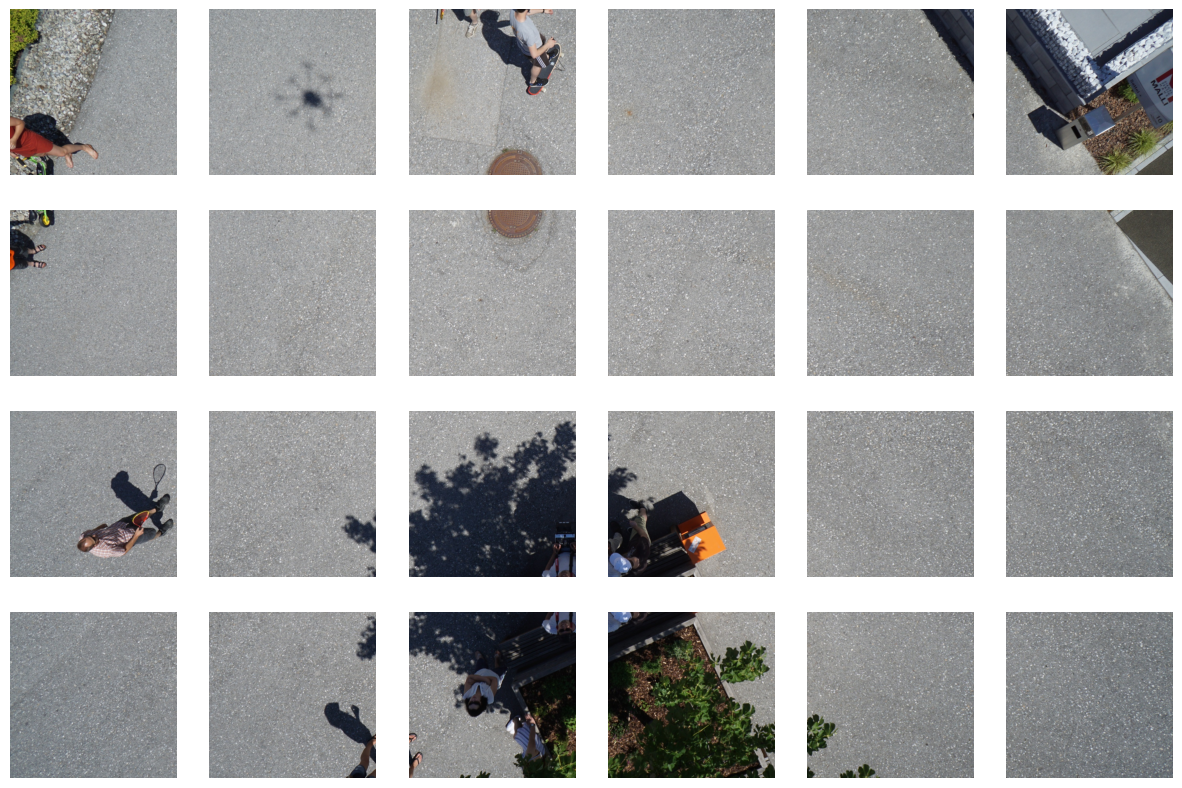

In [18]:
fig, axis = plt.subplots(n_patches_along_height, n_patches_along_width, figsize = (15, 10))
axis = axis.ravel()
for i in range(n_patches_along_height * n_patches_along_width):
    axis[i].imshow(ds[i][0].detach().numpy().transpose(1, 2, 0))
    axis[i].axis('off')
    
plt.show()

In [17]:
i

0